<a href="https://colab.research.google.com/github/safreitas2000/ml-analytics-mvp/blob/main/PNL_transformer_dataset_restaurante_v7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
# instalando dependências
! pip install transformers[torch] datasets evaluate scikit-learn matplotlib #pip install dataset instala biblioteca do hugging face

In [29]:
!pip install gdown

In [57]:
import gdown
import os
import zipfile
import shutil
import pandas as pd
from datasets import Dataset, DatasetDict
import matplotlib.pyplot as plt

In [58]:
CARGA_DADOS = False
CARGA_DADOS_FOLDER_PATH = "/content/modelo_bert_mvp/"
CARGA_DADOS_ZIP_NAME = "tamara_bert_mvp.zip"

In [65]:
if CARGA_DADOS:
  #Excluir arquivos em pasta do COLAB
  if os.path.exists(CARGA_DADOS_FOLDER_PATH):
    shutil.rmtree(CARGA_DADOS_FOLDER_PATH)

  url = "https://drive.google.com/u/0/uc?id=1bZE6Eeh3ruVshJ8Lk5mxAJooidQH8PbT&export=download"

  # Caminho completo para a nova pasta
  os.makedirs(CARGA_DADOS_FOLDER_PATH, exist_ok=True) # cria a pasta de destino se necessário

  zip_file = CARGA_DADOS_FOLDER_PATH + CARGA_DADOS_ZIP_NAME # especifique o nome do arquivo e a extensão do mesmo
  gdown.download(url, zip_file)

In [66]:
if CARGA_DADOS:
  # Abre o arquivo ZIP
  with zipfile.ZipFile(zip_file, 'r') as zip_ref:
      # Extrai todo o conteúdo para a pasta de destino
      zip_ref.extractall(CARGA_DADOS_FOLDER_PATH)

In [34]:
# carregando dados
from datasets import load_dataset

url_test = "https://raw.githubusercontent.com/safreitas2000/ml-analytics-mvp/main/test.csv"
url_train = "https://raw.githubusercontent.com/safreitas2000/ml-analytics-mvp/main/train.csv"

dataset = load_dataset('csv', data_files={'train': url_train, 'test': url_test}, column_names=['text', 'label', 'Recommends'], skiprows=[0])

dataset = dataset.class_encode_column(column="label") # precisa pro trainer saber qual a coluna precisa aprender a predizer

  0%|          | 0/2 [00:00<?, ?it/s]

In [35]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'Recommends'],
        num_rows: 13276
    })
    test: Dataset({
        features: ['text', 'label', 'Recommends'],
        num_rows: 3321
    })
})

In [36]:
dataset = dataset.remove_columns('Recommends')

In [37]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 13276
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3321
    })
})

## Preparação e pre-processamento dos Dados

In [67]:
# Converter o dataset para um DataFrame pandas
df_train = dataset["train"].to_pandas()
df_test = dataset["test"].to_pandas()

df_train.head(10)

,text,label
0,The man who is foodie like me for him arabian ...,4
1,This place is too much comfortable & food is d...,3
2,I check it out like a second home of mine...fe...,2
3,"you guys are awesome & I just love your ""offer...",4
4,Went there after referred by a friend. Tried t...,4
5,I went there for a family dinner . Had the set...,0
6,Everything is great..Perfect for all types of ...,2
7,Last two times we went their with some best bu...,3
8,They served tasty and good quality food,4
9,It is really a good place. Just awesome. Their...,4


In [39]:
# Converter o dataset para um DataFrame pandas
df_train = dataset["train"].to_pandas()
df_test = dataset["test"].to_pandas()

# Remover as linhas com valores vazios ou None
df_train = df_train.dropna()
df_test = df_test.dropna()
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

df_train['label'] = df_train['label'].astype('int64')
df_test['label'] = df_test['label'].astype('int64')

df_train.loc[:, "text"] = df_train["text"].str.encode("ascii", "ignore").str.decode("utf-8")
df_test.loc[:, "text"] = df_test["text"].str.encode("ascii", "ignore").str.decode("utf-8")

# Converter o DataFrame de volta para o formato de Dataset
dataset["train"] = Dataset.from_pandas(df_train)
dataset["test"] = Dataset.from_pandas(df_test)

In [40]:
# gerando datasets menores para treino, validação e teste (para poupar tempo)
small_train_dataset = dataset["train"].shuffle(seed=42).select(range(500,1500)) # pega de 0 a 999 para o treino
small_dev_dataset = dataset["train"].shuffle(seed=42).select(range(1500,2000)) # pega os dados de 1.000 a 1.499 para validação
small_test_dataset = dataset["test"].shuffle(seed=42).select(range(2000,2500)) #pega 500 do teste

In [41]:
df_train.head(10)

,text,label
0,The man who is foodie like me for him arabian ...,4
1,This place is too much comfortable & food is d...,3
2,I check it out like a second home of mine...fe...,2
3,"you guys are awesome & I just love your ""offer...",4
4,Went there after referred by a friend. Tried t...,4
5,I went there for a family dinner . Had the set...,0
6,Everything is great..Perfect for all types of ...,2
7,Last two times we went their with some best bu...,3
8,They served tasty and good quality food,4
9,It is really a good place. Just awesome. Their...,4


## Visualização da Base de Treino e Teste

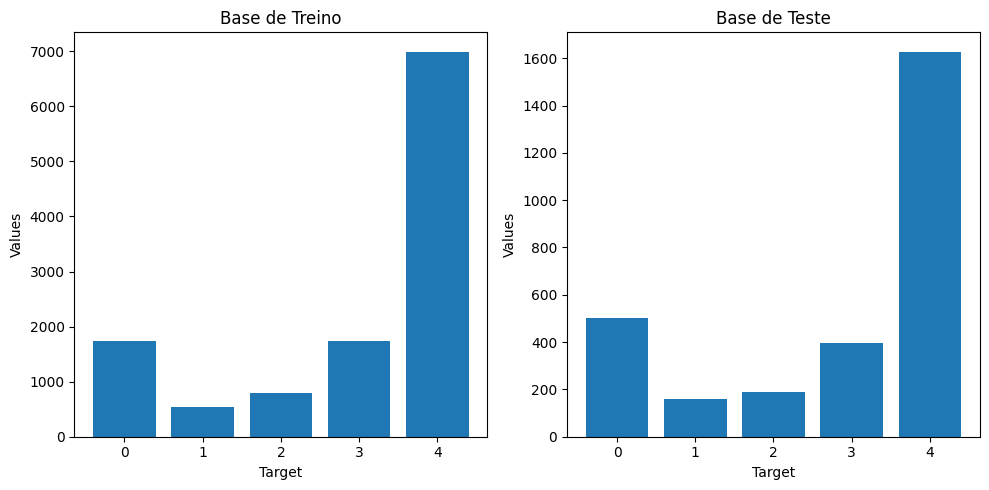

In [42]:
rat_train=df_train.label.value_counts()
rat_test=df_test.label.value_counts()

# Criação da grade de subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plotagem do primeiro gráfico
axes[0].bar(rat_train.index, rat_train.values)
axes[0].set_xticks(rat_train.index)
axes[0].set_xlabel('Target')
axes[0].set_ylabel('Values')
axes[0].set_title('Base de Treino')


# Plotagem do segundo gráfico
axes[1].bar(rat_test.index, rat_test.values)
axes[1].set_xlabel('Target')
axes[1].set_ylabel('Values')
axes[1].set_title('Base de Teste')

# Ajuste de layout e exibição dos gráficos
plt.tight_layout()
plt.show()

In [43]:
#verifica quantos labels únicos temos
set(dataset["train"] ["label"])
#dataset["train"]

{0, 1, 2, 3, 4}

In [44]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 11802
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2876
    })
})

## Pre-processamento utilizando o AutoTokenizer

In [45]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

if CARGA_DADOS:
  MODEL_PATH = '/content/modelo_bert_mvp'
  #carrega o nosso modelo que salvamos no ambiente de execução do colab
  model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
  tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
else:
  #carregando modelo BERT pré-treinado e o tokenizer do modelo pré-treinado
  model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=5)
  tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
#chama a função tokenized e aplica em cada linha do texto
#método map passa uma função em todo o dataset
#o toquenizador criou input_ids', 'token_type_ids', 'attention_mask'
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_small_train_dataset = small_train_dataset.map(tokenize_function, batched=True)
tokenized_small_dev_dataset = small_dev_dataset.map(tokenize_function, batched=True)
#tokenized_small_test_dataset = small_test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [47]:
#visualização do dataset
small_train_df = pd.DataFrame(tokenized_small_train_dataset)
small_train_df.head(10)

,text,label,input_ids,token_type_ids,attention_mask
0,Great place for some hakka chinese food. Somet...,4,"[101, 2038, 1282, 1111, 1199, 5871, 19610, 514...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,Food quality could be better.....otherwise goo...,2,"[101, 6702, 3068, 1180, 1129, 1618, 119, 119, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,The page needs to be updated. Price has increa...,2,"[101, 1109, 3674, 2993, 1106, 1129, 8054, 119,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,Excellent service!,4,"[101, 25764, 1555, 106, 102, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Very good environment and very delicious food....,4,"[101, 6424, 1363, 3750, 1105, 1304, 13108, 209...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
5,I dont usually write reviews but this was one ...,0,"[101, 146, 1274, 1204, 1932, 3593, 3761, 1133,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
6,Tasty & Yummy Foods !! I love it !! Keep...,4,"[101, 22515, 13913, 111, 10684, 16211, 21015, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
7,I dont understand why people give 5 star to th...,0,"[101, 146, 1274, 1204, 2437, 1725, 1234, 1660,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
8,Sub-per sitting arrangement due for Ramadan ca...,0,"[101, 12859, 118, 1679, 2807, 6204, 1496, 1111...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
9,It's wonderful. Fantastic experience. I loved ...,4,"[101, 1135, 112, 188, 7310, 119, 19420, 2541, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


## Definição do modelo

In [48]:
from transformers import Trainer, TrainingArguments
import numpy as np
import evaluate #biblioteca para carregar métrica

metric = evaluate.load("accuracy")

#cria uma função para computar a métrica
def compute_metrics(eval_pred): #eval_pred é o que o modelo previu
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1) #pega o id que tem maior probabilidade
    return metric.compute(predictions=predictions, references=labels) #compara o ID predito com o label esperado

#onde vai salvar o modelo treinado
MODEL_PATH = "/content/modelo_bert_mvp/tamara_bert_mvp"

training_args = TrainingArguments(
    output_dir=MODEL_PATH,
    evaluation_strategy="steps", #fazer o evaluation no step de validação a cada 10 steps
    eval_steps=10,
    per_device_train_batch_size=8,#8
    per_device_eval_batch_size=8,#8
    gradient_accumulation_steps=4, #4 gradient_accumulation_steps* per_device_eval_batch_size=batch
    max_steps=200,  # 200 por quantos steps eu quero treinar o modelo
    learning_rate=3e-5, #3e-5
    logging_strategy="steps", #a cada 10 steps vai printar
    logging_steps=10,
    save_steps=50, #salvar check point a cada 50 steps
    load_best_model_at_end=True, #pega o melhor dos que salvou
    metric_for_best_model="accuracy",
    greater_is_better=True, #se for maior é bom pq acurácia é medida de acerto
    save_total_limit=2, #quantos checkpoints vai salvar
    disable_tqdm=False #aparece a barrinha carregando
)
#entra com o modelo definido acima, os argumentos e os datasets, o trainer espera a função que computa a métrica
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_small_train_dataset,
    eval_dataset=tokenized_small_dev_dataset,
    compute_metrics=compute_metrics,
)

# Treinamento

In [49]:
if not CARGA_DADOS:
  trainer.train() #treina o modelo

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
10,1.423500,1.206847,0.606000
20,1.196100,1.085512,0.622000
30,1.033100,0.957629,0.686000
40,0.973200,0.949557,0.694000
50,0.885000,0.891812,0.680000
60,0.794900,0.863363,0.698000
70,0.766900,0.847792,0.694000
80,0.700800,0.848114,0.690000
90,0.737600,0.836255,0.708000
100,0.725700,0.800860,0.710000


## Plotagem

In [51]:
#verifica se loss está muito ruidoso (sobe e desce) que o learning rate pode estar muito alto ou o dado estar ruim
if CARGA_DADOS:
  df_log = pd.read_csv('/content/modelo_bert_mvp/historico_treinamento.csv')
else:
  #Salva os dados do historico do treinamento em arquivo CSV
  df_log = pd.DataFrame(trainer.state.log_history)
  df_log.to_csv('/content/modelo_bert_mvp/tamara_bert_mvp/historico_treinamento.csv', index=False)
  #salva o modelo e o tokenizador
  trainer.save_model(MODEL_PATH)
  tokenizer.save_pretrained(MODEL_PATH)

df_log

,loss,learning_rate,epoch,step,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,1.4235,0.000028,0.32,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,0.32,10,1.206847,0.606,16.2765,30.719,3.871,NaN,NaN,NaN,NaN,NaN
2,1.1961,0.000027,0.64,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,0.64,20,1.085512,0.622,15.7287,31.789,4.005,NaN,NaN,NaN,NaN,NaN
4,1.0331,0.000025,0.96,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,0.96,30,0.957629,0.686,16.0210,31.209,3.932,NaN,NaN,NaN,NaN,NaN
6,0.9732,0.000024,1.28,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,1.28,40,0.949557,0.694,15.8015,31.643,3.987,NaN,NaN,NaN,NaN,NaN
8,0.8850,0.000023,1.60,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,1.60,50,0.891812,0.680,15.8098,31.626,3.985,NaN,NaN,NaN,NaN,NaN


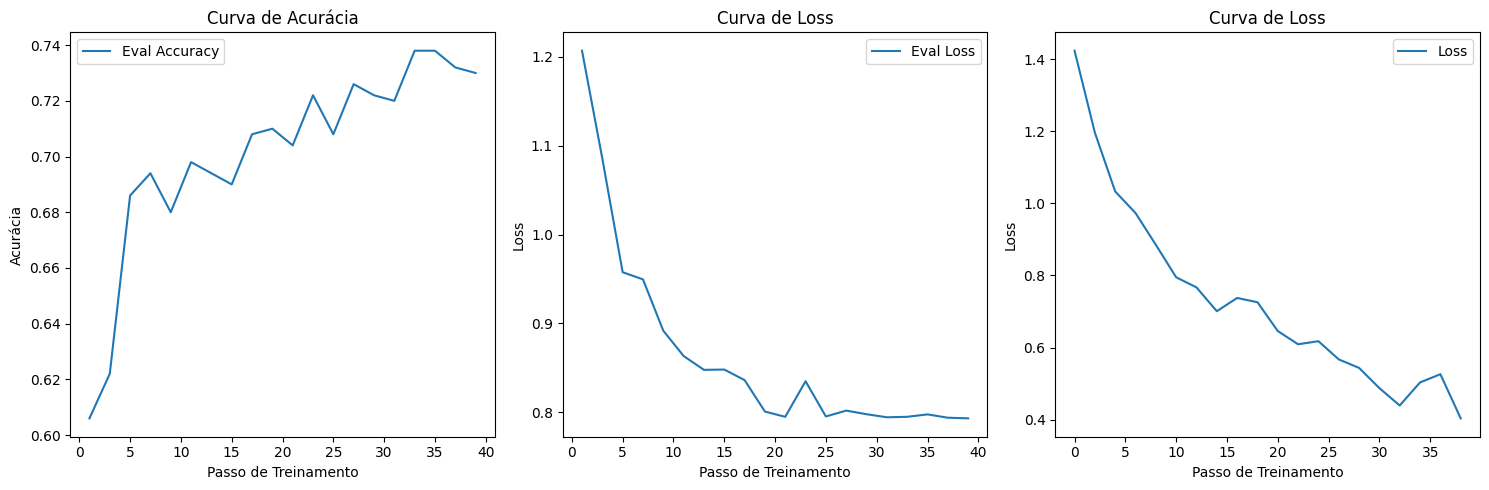

In [52]:
# Criar uma figura e eixos para os subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plotar a curva de eval_accuracy
axes[0].plot(df_log["eval_accuracy"].dropna())
axes[0].set_xlabel('Passo de Treinamento')
axes[0].set_ylabel('Acurácia')
axes[0].set_title('Curva de Acurácia')

# Plotar a curva de eval_loss
axes[1].plot(df_log["eval_loss"].dropna())
axes[1].set_xlabel('Passo de Treinamento')
axes[1].set_ylabel('Loss')
axes[1].set_title('Curva de Loss')

# Plotar a curva de loss
axes[2].plot(df_log["loss"].dropna())
axes[2].set_xlabel('Passo de Treinamento')
axes[2].set_ylabel('Loss')
axes[2].set_title('Curva de Loss')

# Adicionar legendas
axes[0].legend(["Eval Accuracy"])
axes[1].legend(["Eval Loss"])
axes[2].legend(["Loss"])

# Ajustar o espaçamento entre os subplots
plt.tight_layout()

# Exibir os gráficos lado a lado
plt.show()

## Outros

In [53]:
small_test_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 500
})

In [54]:
from sklearn.metrics import accuracy_score
import torch

# Criar uma lista para armazenar as predições
predictions = []
real = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Iterar sobre as amostras do dataset
for example in small_test_dataset:
    # Tokenizar o texto
    encoded_input = tokenizer(example["text"], return_tensors="pt")

    # Mover os dados para o mesmo dispositivo (CPU ou GPU) do modelo
    encoded_input = {key: tensor.to(device) for key, tensor in encoded_input.items()}

    # Passar os dados tokenizados pelo modelo
    output = model(**encoded_input)
    probs = torch.softmax(output.logits, dim=1)
    pred = torch.argmax(probs, dim=1).item()
    #print(probs)
    # Armazenar a predição na lista de predições
    predictions.append(pred)
    real.append(example["label"])

# Imprimir as predições
accuracy = accuracy_score(real, predictions)
print(f"Acurácia: {accuracy}")
#print(predictions)
#print(real)

Acurácia: 0.732


Text(50.722222222222214, 0.5, 'Truth')

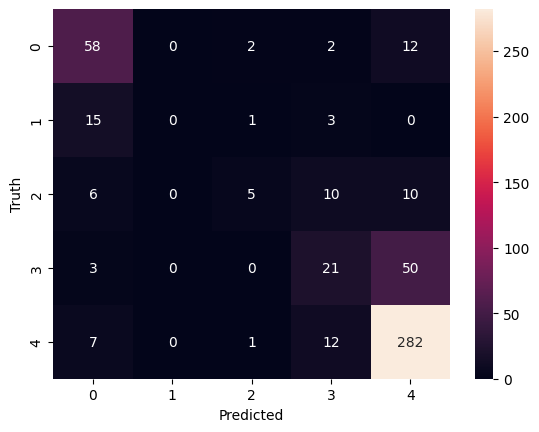

In [55]:
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
import seaborn as sns

cm=confusion_matrix(real,predictions)
sns.heatmap(cm,annot=True,fmt='d')

plt.xlabel("Predicted")
plt.ylabel("Truth")